<a href="https://colab.research.google.com/github/jayeshsaini/Data-Lit/blob/master/Denoising_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Homework Assignment (Denoising Autoencoder)

Im based on the work published in kaggle by Aakash Nain 
 https://www.kaggle.com/aakashnain/denoising-autoencoders-to-the-rescue/notebook (credits for their great work) to solve a homework assigment of Datalit (https://www.theschool.ai/courses/data-lit ). From this I made some other experiments with different configurations, particularly using a different optimizer algorithm and the same Adam algorithim but with more epochs (20,30) and a more bigger batch size , to take advantage of google colab GPU.It can be noted that the main idea of this notebook is try to understand the functionality of the autoencoders and their possible applications and not to go deeper.    


In [1]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       2768            True  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11028            True  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4470            True  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         39           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       2732           False  
two-sigma-financial-news                           2019-07-15 23:59:00  Featured          $100,000      

In [3]:
!kaggle competitions download denoising-dirty-documents

train_cleaned.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip train_cleaned.zip 
!unzip train.zip
!unzip test.zip

Archive:  train_cleaned.zip
replace train_cleaned/101.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  train.zip
replace train/101.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

KeyboardInterrupt: ignored

In [5]:
!ls

sample_data		  test	    train	       train.csv
sample_submission.csv	  test.csv  train_cleaned      train.zip
sampleSubmission.csv.zip  test.zip  train_cleaned.zip


In [6]:
# Import some importante libraries

import os
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


sample_data
sample_submission.csv
sampleSubmission.csv.zip
test
test.csv
test.zip
train
train_cleaned
train_cleaned.zip
train.csv
train.zip



In [0]:
# Now we define all the directories in Gdrive, of the dataset

train = './train'
train_cleaned = './train_cleaned'
test = './test'

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


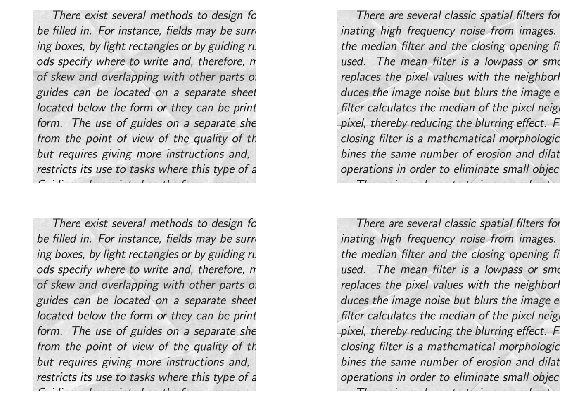

In [8]:
# Next, check if the directories work well and shown some samples

train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

# Samples

samples = train_images[:2] + train_labels[:2]
s1='/'

f, ax = plt.subplots(2, 2, figsize=(10,7))
for i, img in enumerate(samples):
    img = imread(train+s1+img)
    ax[i//2, i%2].imshow(img, cmap='gray')
    ax[i//2, i%2].axis('off')
    
plt.show()    

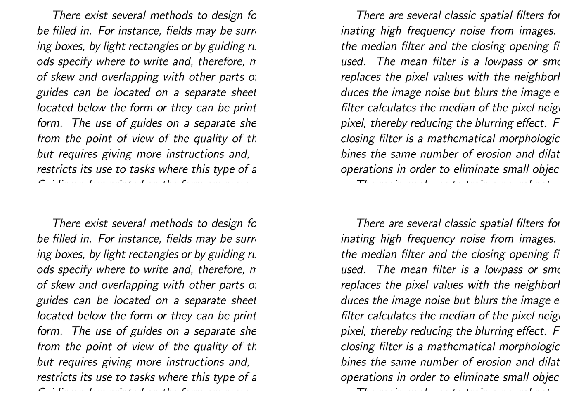

In [9]:
# The cleaned samples

f, ax = plt.subplots(2, 2, figsize=(10,7))
for i, img in enumerate(samples):
    img = imread(train_cleaned+s1+img)
    ax[i//2, i%2].imshow(img, cmap='gray')
    ax[i//2, i%2].axis('off')

In [0]:
# This is the structure of the autoencoder, can be noticed the bottleneck in 
# the middle 

def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #encoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='sgd', loss='binary_crossentropy')
    return autoencoder

In [11]:
#We can see a summary of our autoencoder defined in this case we use the Stochastic Gradient Descent algorithm (sgd) as optimizer

autoencoder = build_autoenocder()
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 420, 540, 1)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 105, 135, 64)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 105, 135, 64)      36928     
_________________________________________________________________
upsa

I followed the strategy of Aakash Nain due to the small dataset. So I used lot numpy arrays that contains all the images.

In [12]:
X = []
Y = []

for img in train_images:
    img = load_img(train +s1+ img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned +s1+ img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [0]:
# After the training phase, lest split the dataset.

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)


In [14]:
# Train the model

autoencoder.fit(X_train, y_train, epochs=30, batch_size=20, validation_data=(X_valid, y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 129 samples, validate on 15 samples
Epoch 1/30
129/129 [==============================] - 13s 101ms/step - loss: 0.6445 - val_loss: 0.5750
Epoch 2/30
129/129 [==============================] - 3s 27ms/step - loss: 0.5301 - val_loss: 0.4677
Epoch 3/30
129/129 [==============================] - 3s 27ms/step - loss: 0.4299 - val_loss: 0.3904
Epoch 4/30
129/129 [==============================] - 3s 27ms/step - loss: 0.3712 - val_loss: 0.3629
Epoch 5/30
129/129 [==============================] - 3s 27ms/step - loss: 0.3536 - val_loss: 0.3574
Epoch 6/30
129/129 [==============================] - 3s 27ms/step - loss: 0.3498 - val_loss: 0.3562
Epoch 7/30
129/129 [==============================] - 3s 27ms/step - loss: 0.3488 - val_loss: 0.3556
Epoch 8/30
129/129 [==============================] - 3s 27ms/step - loss: 0.3481 - val_loss: 0.3551
Epoch 9/30
129/129 [==============================] - 3s 27ms/step - loss: 0.3477 - val_loss: 0.3

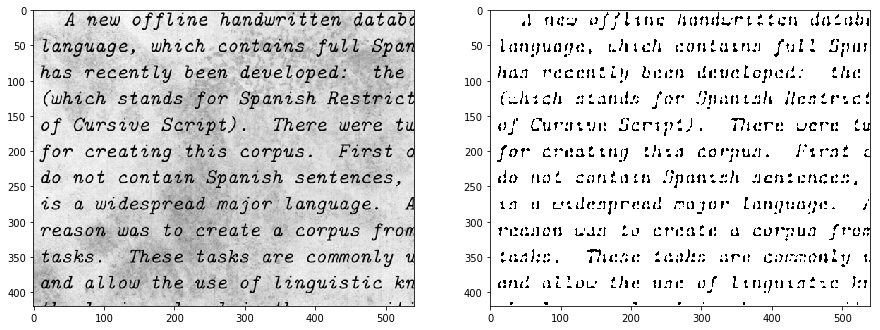

In [19]:
# With the model trainied we see the results on and image

sample_test = load_img(test +s1+test_images[11], target_size=(420,540), color_mode = "grayscale")
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)


predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(15,16))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

In this case the image resultant doesn't satisfy our requirement, in fact the model erase all the image as if all is noise xD (it's the first test so) , so next there are others experiments to improve this results.

In [0]:
# Now we define the autoencoder but using the Adam optimizer

def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [17]:
autoencoder = build_autoenocder()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 420, 540, 1)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 105, 135, 64)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 105, 135, 64)      36928     
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 210, 270, 64)      0         
__________

In [18]:
# Train the model with the new optimizer

autoencoder.fit(X_train, y_train, epochs=20, batch_size=20, validation_data=(X_valid, y_valid))

Train on 129 samples, validate on 15 samples
Epoch 1/20
129/129 [==============================] - 4s 31ms/step - loss: 0.5648 - val_loss: 0.3928
Epoch 2/20
129/129 [==============================] - 3s 27ms/step - loss: 0.3990 - val_loss: 0.3710
Epoch 3/20
129/129 [==============================] - 3s 27ms/step - loss: 0.3709 - val_loss: 0.3614
Epoch 4/20
129/129 [==============================] - 3s 27ms/step - loss: 0.3549 - val_loss: 0.3576
Epoch 5/20
129/129 [==============================] - 3s 27ms/step - loss: 0.3446 - val_loss: 0.3421
Epoch 6/20
129/129 [==============================] - 3s 27ms/step - loss: 0.3261 - val_loss: 0.3181
Epoch 7/20
129/129 [==============================] - 3s 27ms/step - loss: 0.2997 - val_loss: 0.2832
Epoch 8/20
129/129 [==============================] - 3s 27ms/step - loss: 0.2695 - val_loss: 0.2627
Epoch 9/20
129/129 [==============================] - 3s 27ms/step - loss: 0.2526 - val_loss: 0.2506
Epoch 10/20
129/129 [=========================

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


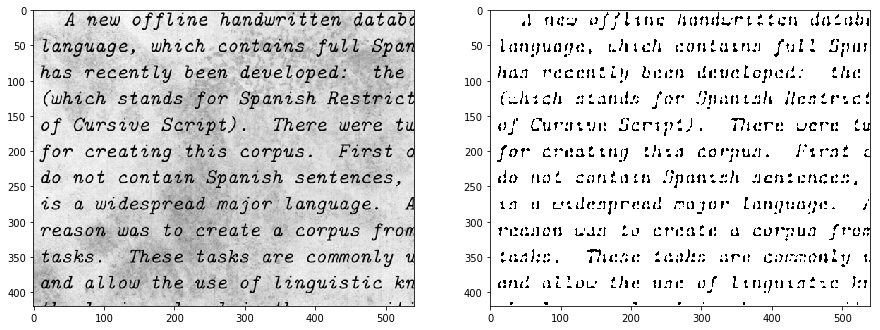

In [20]:
# Plot the results 


sample_test = load_img(test +s1+test_images[11], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(15,16))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

Now the results are better and we are in the right way, so next we try with a more epochs to improve their results.

In [21]:
autoencoder = build_autoenocder()

autoencoder.fit(X_train, y_train, epochs=30, batch_size=20, validation_data=(X_valid, y_valid))

Train on 129 samples, validate on 15 samples
Epoch 1/30
129/129 [==============================] - 4s 31ms/step - loss: 0.5319 - val_loss: 0.4139
Epoch 2/30
129/129 [==============================] - 3s 27ms/step - loss: 0.3869 - val_loss: 0.3650
Epoch 3/30
129/129 [==============================] - 3s 27ms/step - loss: 0.3612 - val_loss: 0.3547
Epoch 4/30
129/129 [==============================] - 3s 27ms/step - loss: 0.3470 - val_loss: 0.3466
Epoch 5/30
129/129 [==============================] - 3s 27ms/step - loss: 0.3361 - val_loss: 0.3319
Epoch 6/30
129/129 [==============================] - 3s 27ms/step - loss: 0.3159 - val_loss: 0.3043
Epoch 7/30
129/129 [==============================] - 3s 27ms/step - loss: 0.2831 - val_loss: 0.2676
Epoch 8/30
129/129 [==============================] - 3s 27ms/step - loss: 0.2539 - val_loss: 0.2508
Epoch 9/30
129/129 [==============================] - 3s 27ms/step - loss: 0.2421 - val_loss: 0.2416
Epoch 10/30
129/129 [=========================

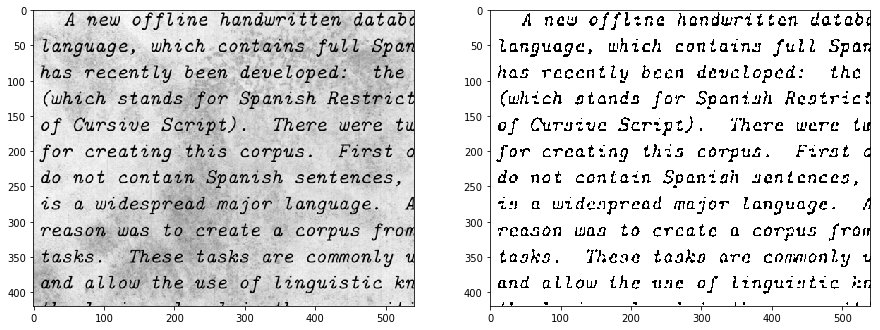

In [23]:
# Let's test our model on a sample test image
sample_test = load_img(test +s1+test_images[11], color_mode = "grayscale", target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(15,16))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

Now the results are quite good, the next step is go deeper but for now we fulfil the main idea. Again thanks for the great contribution of Aakash Nain and to the people behind the datalit course. :D